In [1]:
!pip install fredapi > /dev/null # installing fred api 

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 500)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()['color']

from fredapi import Fred

#fred_key='0d9334e1e7180c717a3f894e5404c9c0'

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
fred_key = user_secrets.get_secret("fred_api")

# 1. Create The fred Object

In [3]:
fred = Fred(api_key=fred_key)

# 2. Search for economic data 

In [4]:
sp_search=fred.search('S&P' ,order_by= 'popularity') 

In [5]:
sp_search.head()

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
BAMLH0A0HYM2,BAMLH0A0HYM2,2024-07-29,2024-07-29,ICE BofA US High Yield Index Option-Adjusted S...,1996-12-31,2024-07-25,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2024-07-26 08:26:08-05:00,92,The ICE BofA Option-Adjusted Spreads (OASs) ar...
CSUSHPINSA,CSUSHPINSA,2024-07-29,2024-07-29,S&P CoreLogic Case-Shiller U.S. National Home ...,1987-01-01,2024-04-01,Monthly,M,Index Jan 2000=100,Index Jan 2000=100,Not Seasonally Adjusted,NSA,2024-06-25 08:12:01-05:00,88,"For more information regarding the index, plea..."
SP500,SP500,2024-07-29,2024-07-29,S&P 500,2014-07-28,2024-07-26,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2024-07-26 19:52:45-05:00,83,The observations for the S&P 500 represent the...
MEHOINUSA672N,MEHOINUSA672N,2024-07-29,2024-07-29,Real Median Household Income in the United States,1984-01-01,2022-01-01,Annual,A,2022 CPI-U-RS Adjusted Dollars,2022 CPI-U-RS Adjusted $,Not Seasonally Adjusted,NSA,2023-09-12 13:48:02-05:00,83,Household data are collected as of March. As ...
BAMLH0A0HYM2EY,BAMLH0A0HYM2EY,2024-07-29,2024-07-29,ICE BofA US High Yield Index Effective Yield,1996-12-31,2024-07-25,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2024-07-26 08:26:11-05:00,82,This data represents the effective yield of th...


# 3. pull row data and plot

In [6]:
sp500 = fred.get_series(series_id='SP500')

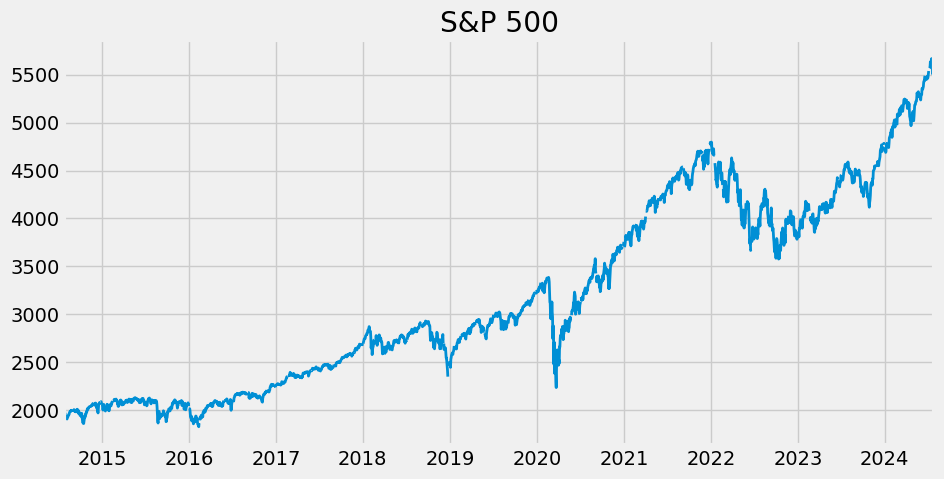

In [7]:
sp500.plot(figsize=(10,5) , title='S&P 500' , lw=2 )
plt.show()

# 4. pull and join multiple data series 

In [8]:
unemp_df = fred.search('unemployment rate state', filter=('frequency','Monthly'))
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate')]

In [9]:
all_results = []

for myid in unemp_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    #time.sleep(0.1) # Don't request to fast and get blocked
uemp_results = pd.concat(all_results, axis=1)

In [10]:
cols_to_drop = []
for i in uemp_results:
    if len(i) > 4:
        cols_to_drop.append(i)
uemp_results = uemp_results.drop(columns = cols_to_drop, axis=1)

In [11]:
uemp_states = uemp_results.copy()  #.drop('UNRATE', axis=1)
uemp_states = uemp_states.dropna()
id_to_state = unemp_df['title'].str.replace('Unemployment Rate in ','').to_dict() # converting ID to state for better understanding of place 
uemp_states.columns = [id_to_state[c] for c in uemp_states.columns]

In [12]:
# Plot States Unemployment Rate
px.line(uemp_states)

# pull April 2020 Unemployment Rate Per state 

<Axes: title={'center': 'Unemployment Rate by State ; June 2024'}>

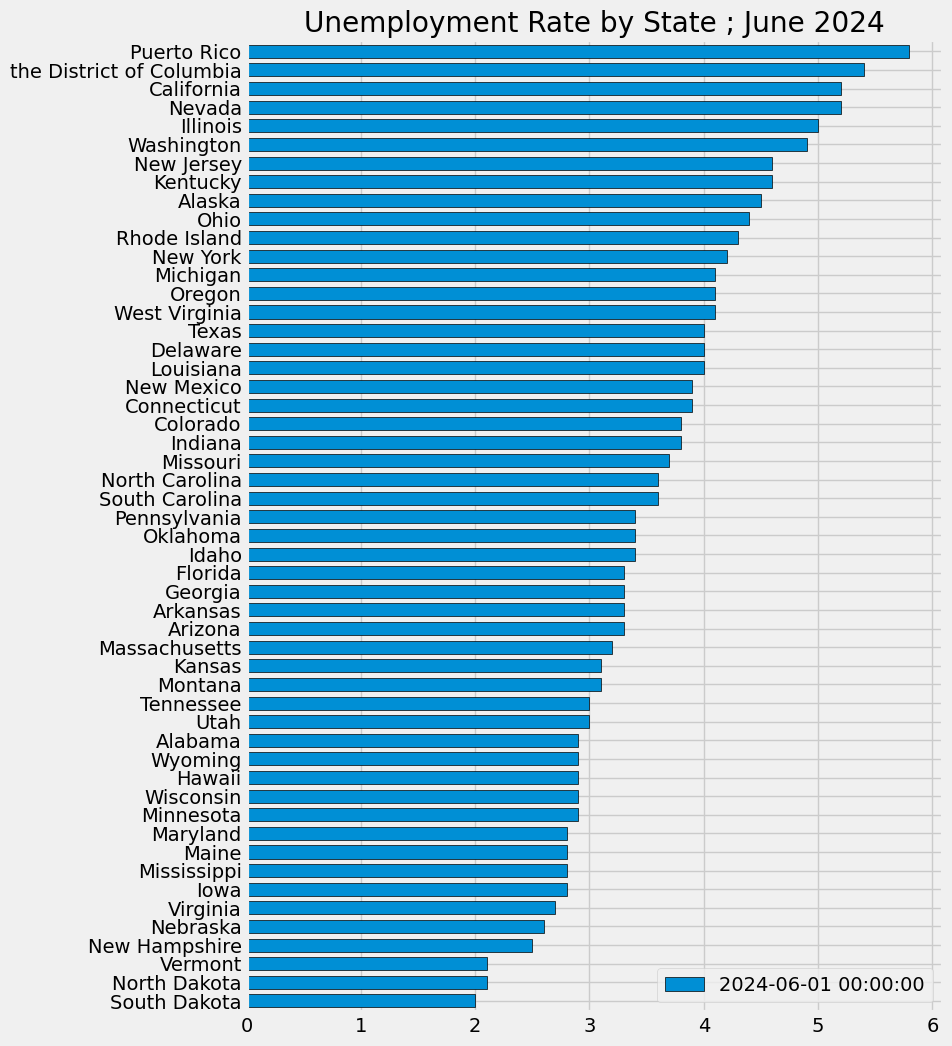

In [13]:
uemp_states.loc[uemp_states.index =='2024-06-01'].T\
.sort_values('2024-06-01')\
.plot(kind='barh' , figsize=(8,12) ,width=0.7, edgecolor='black' , title="Unemployment Rate by State ; June 2024")

# 5. Pull Participation Rate 

In [14]:
part_df = fred.search('participation Rate state', filter=('frequency','Monthly'))
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')

In [15]:
part_id_to_state = part_df['title'].str.replace('Labor Force Participation Rate for ','').to_dict()

all_results = []

for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    #time.sleep(0.1) # Don't request to fast and get blocked
part_states = pd.concat(all_results, axis=1)
part_states.columns = [part_id_to_state[c] for c in part_states.columns]

# Plot Unemployment vs Participation 

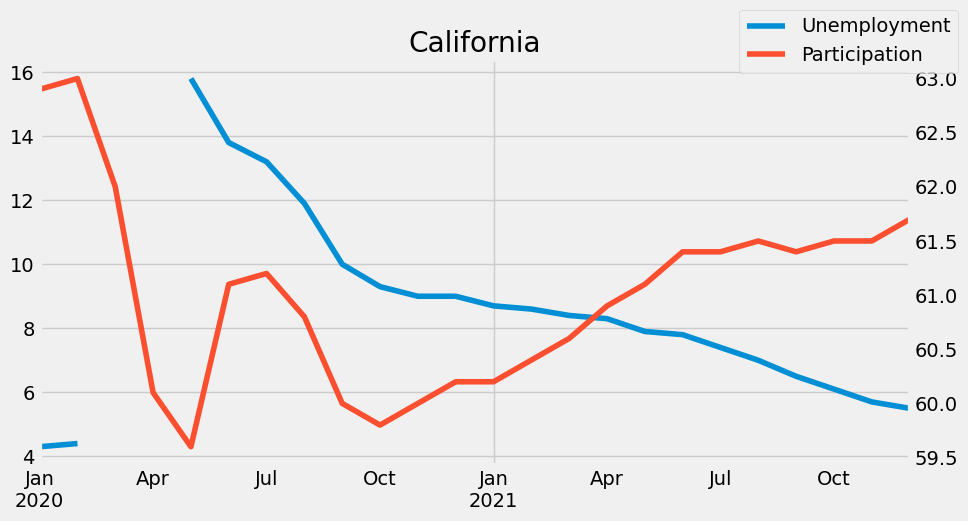

In [16]:
state = 'California'
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
ax2 = ax.twinx()
uemp_states2 = uemp_states.asfreq('MS')
l1 = uemp_states2.query('index >= 2020 and index < 2022')[state] \
    .plot(ax=ax, label='Unemployment')
l2 = part_states.dropna().query('index >= 2020 and index < 2022')[state] \
    .plot(ax=ax2, label='Participation', color=color_pal[1])
ax2.grid(False)
ax.set_title(state)
fig.legend(labels=['Unemployment','Participation'])
plt.show()